In [215]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn
% matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline

In [2]:
np.random.seed(3)

Equation for the effort-incentives curve: Effort = 10 x (1-exp(-Incentives/400))

Equation for the % improvement in renewal prob vs effort curve: % Improvement = 20 x (1-exp(-Effort/5))

% Improvement = 20 x (1-exp(-10 x (1-exp(-Incentives/400))/5))


In [3]:
test = pd.read_csv('test_66516Ee.csv')

In [4]:
train = pd.read_csv('train_ZoGVYWq.csv')

In [5]:
raw_train = pd.read_csv('train_ZoGVYWq.csv')

In [6]:
train.shape

(79853, 13)

In [7]:
train.describe()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal
count,79853.000000,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000,79853.000000
mean,57167.166368,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,10924.507533,0.937410
std,32928.970160,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,9401.676542,0.242226
min,2.000000,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000,0.000000
25%,28640.000000,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,5400.000000,1.000000
50%,57262.000000,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000,1.000000
75%,85632.000000,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,13800.000000,1.000000
max,114076.000000,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000,1.000000


In [8]:
# Check number of np.nan cells
for k in raw_train.columns:
    print(k)
    print(train[k].isnull().sum()/len(train))

id
0.0
perc_premium_paid_by_cash_credit
0.0
age_in_days
0.0
Income
0.0
Count_3-6_months_late
0.0012147320701789538
Count_6-12_months_late
0.0012147320701789538
Count_more_than_12_months_late
0.0012147320701789538
application_underwriting_score
0.03724343481146607
no_of_premiums_paid
0.0
sourcing_channel
0.0
residence_area_type
0.0
premium
0.0
renewal
0.0


### rename cols

In [9]:
train.rename(columns={
    'Income' : 'income',
    'age_in_days' : 'age',
    'perc_premium_paid_by_cash_credit' : 'trad_payment',
    'Count_3-6_months_late' : 'late_3_6m',
    'Count_6-12_months_late' : 'late_6_12m',
    'Count_more_than_12_months_late' : 'late_12m',
    'application_underwriting_score' : 'app_score',
    'no_of_premiums_paid' : 'count_premiums_paid'
    },
    inplace=True)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 13 columns):
id                     79853 non-null int64
trad_payment           79853 non-null float64
age                    79853 non-null int64
income                 79853 non-null int64
late_3_6m              79756 non-null float64
late_6_12m             79756 non-null float64
late_12m               79756 non-null float64
app_score              76879 non-null float64
count_premiums_paid    79853 non-null int64
sourcing_channel       79853 non-null object
residence_area_type    79853 non-null object
premium                79853 non-null int64
renewal                79853 non-null int64
dtypes: float64(5), int64(6), object(2)
memory usage: 7.9+ MB


In [11]:
train['income'] = np.log(train['income'])
train['urban'] = train['residence_area_type'].isin(['Urban'])

In [12]:
train.drop(labels=['residence_area_type'], axis=1, inplace=True)

# Fix remapping app_score = looks like it has been truncated

In [13]:
99.9-91.9

8.0

In [14]:
np.std(train['app_score'])

0.7397942039489025

/home/kt12/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


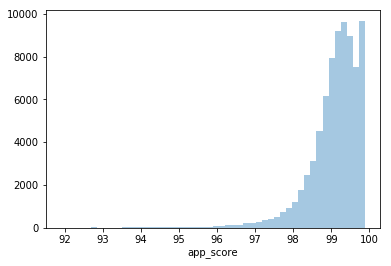

In [15]:
sns.distplot(train['app_score'].dropna(), kde=False)

/home/kt12/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


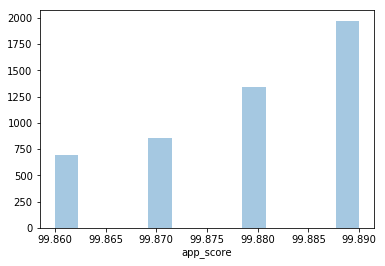

In [16]:
sns.distplot(train[train['app_score']>99.85]['app_score'].dropna(), kde=False)

In [17]:
len(train[train['app_score']>99.85])

4864

/home/kt12/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


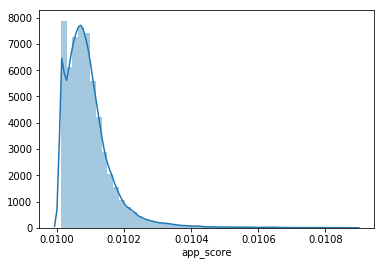

In [18]:
sns.distplot(1/train['app_score'].dropna())

/home/kt12/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


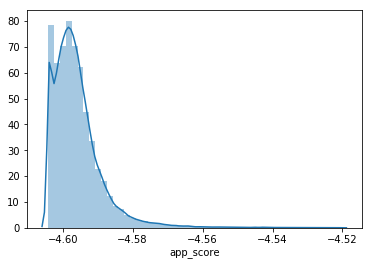

In [19]:
sns.distplot(np.log(1/train['app_score'].dropna()))

/home/kt12/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


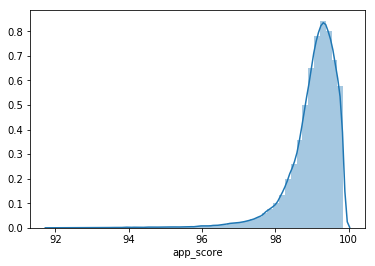

In [20]:
sns.distplot(train[train['app_score']<=99.85]['app_score'])

/home/kt12/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


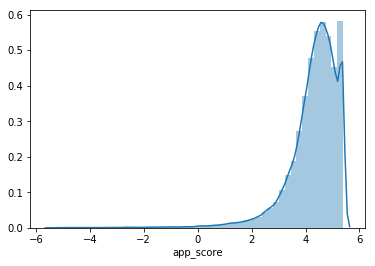

In [21]:
sns.distplot((train['app_score'].dropna() - 95.9)/.74)

In [22]:
bell_app = train[~train['app_score'].isnull()].copy()

In [23]:
bell_app.isnull().sum()

id                      0
trad_payment            0
age                     0
income                  0
late_3_6m              24
late_6_12m             24
late_12m               24
app_score               0
count_premiums_paid     0
sourcing_channel        0
premium                 0
renewal                 0
urban                   0
dtype: int64

In [24]:
train.dropna(axis=0, how='any')

,id,trad_payment,age,income,late_3_6m,late_6_12m,late_12m,app_score,count_premiums_paid,sourcing_channel,premium,renewal,urban
0,110936,0.429,12058,12.780042,0.0,0.0,0.0,99.02,13,C,3300,1,True
1,41492,0.010,21546,12.660804,0.0,0.0,0.0,99.89,21,A,18000,1,True
2,31300,0.917,17531,11.340237,2.0,3.0,1.0,98.69,7,C,3300,0,False
3,19415,0.049,15341,12.431254,0.0,0.0,0.0,99.57,9,A,9600,1,True
4,99379,0.052,31400,12.199451,0.0,0.0,0.0,99.87,12,B,9600,1,True
5,59951,0.540,17527,12.549946,2.0,0.0,0.0,99.18,9,B,22200,1,False
6,54031,1.000,24829,11.681824,0.0,0.0,0.0,99.05,11,B,7500,1,True
7,94290,1.000,21911,12.102045,1.0,6.0,4.0,99.33,3,A,9600,0,True
8,93730,0.621,9868,11.435180,0.0,0.0,0.0,99.58,4,A,7500,1,True
9,84844,0.908,23008,11.582265,2.0,0.0,0.0,98.91,11,A,5400,0,False


/home/kt12/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


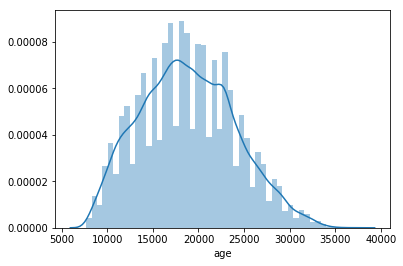

In [25]:
sns.distplot(train['age'].dropna())

/home/kt12/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


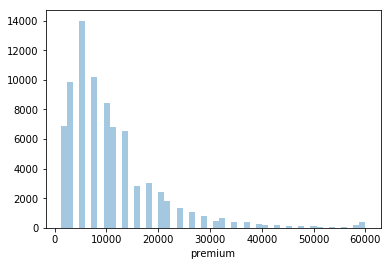

In [26]:
sns.distplot(train['premium'], kde=False)

In [27]:
train.drop('id', axis=1, inplace=True)

In [28]:
train['source_a'] = train['sourcing_channel'].isin(['A'])
train['source_b'] = train['sourcing_channel'].isin(['B'])
train['source_c'] = train['sourcing_channel'].isin(['C'])
train['source_d'] = train['sourcing_channel'].isin(['D'])
train['source_e'] = train['sourcing_channel'].isin(['E'])

In [29]:
train.drop(labels=['sourcing_channel'], axis=1, inplace=True)

In [30]:
train['late_3_6m'].fillna(train['late_3_6m'].median(),inplace=True)
train['late_6_12m'].fillna(train['late_6_12m'].median(),inplace=True)
train['late_12m'].fillna(train['late_12m'].median(),inplace=True)
train['app_score'].fillna(train['app_score'].median(),inplace=True)

In [31]:
train['age'] = train['age'] / 365

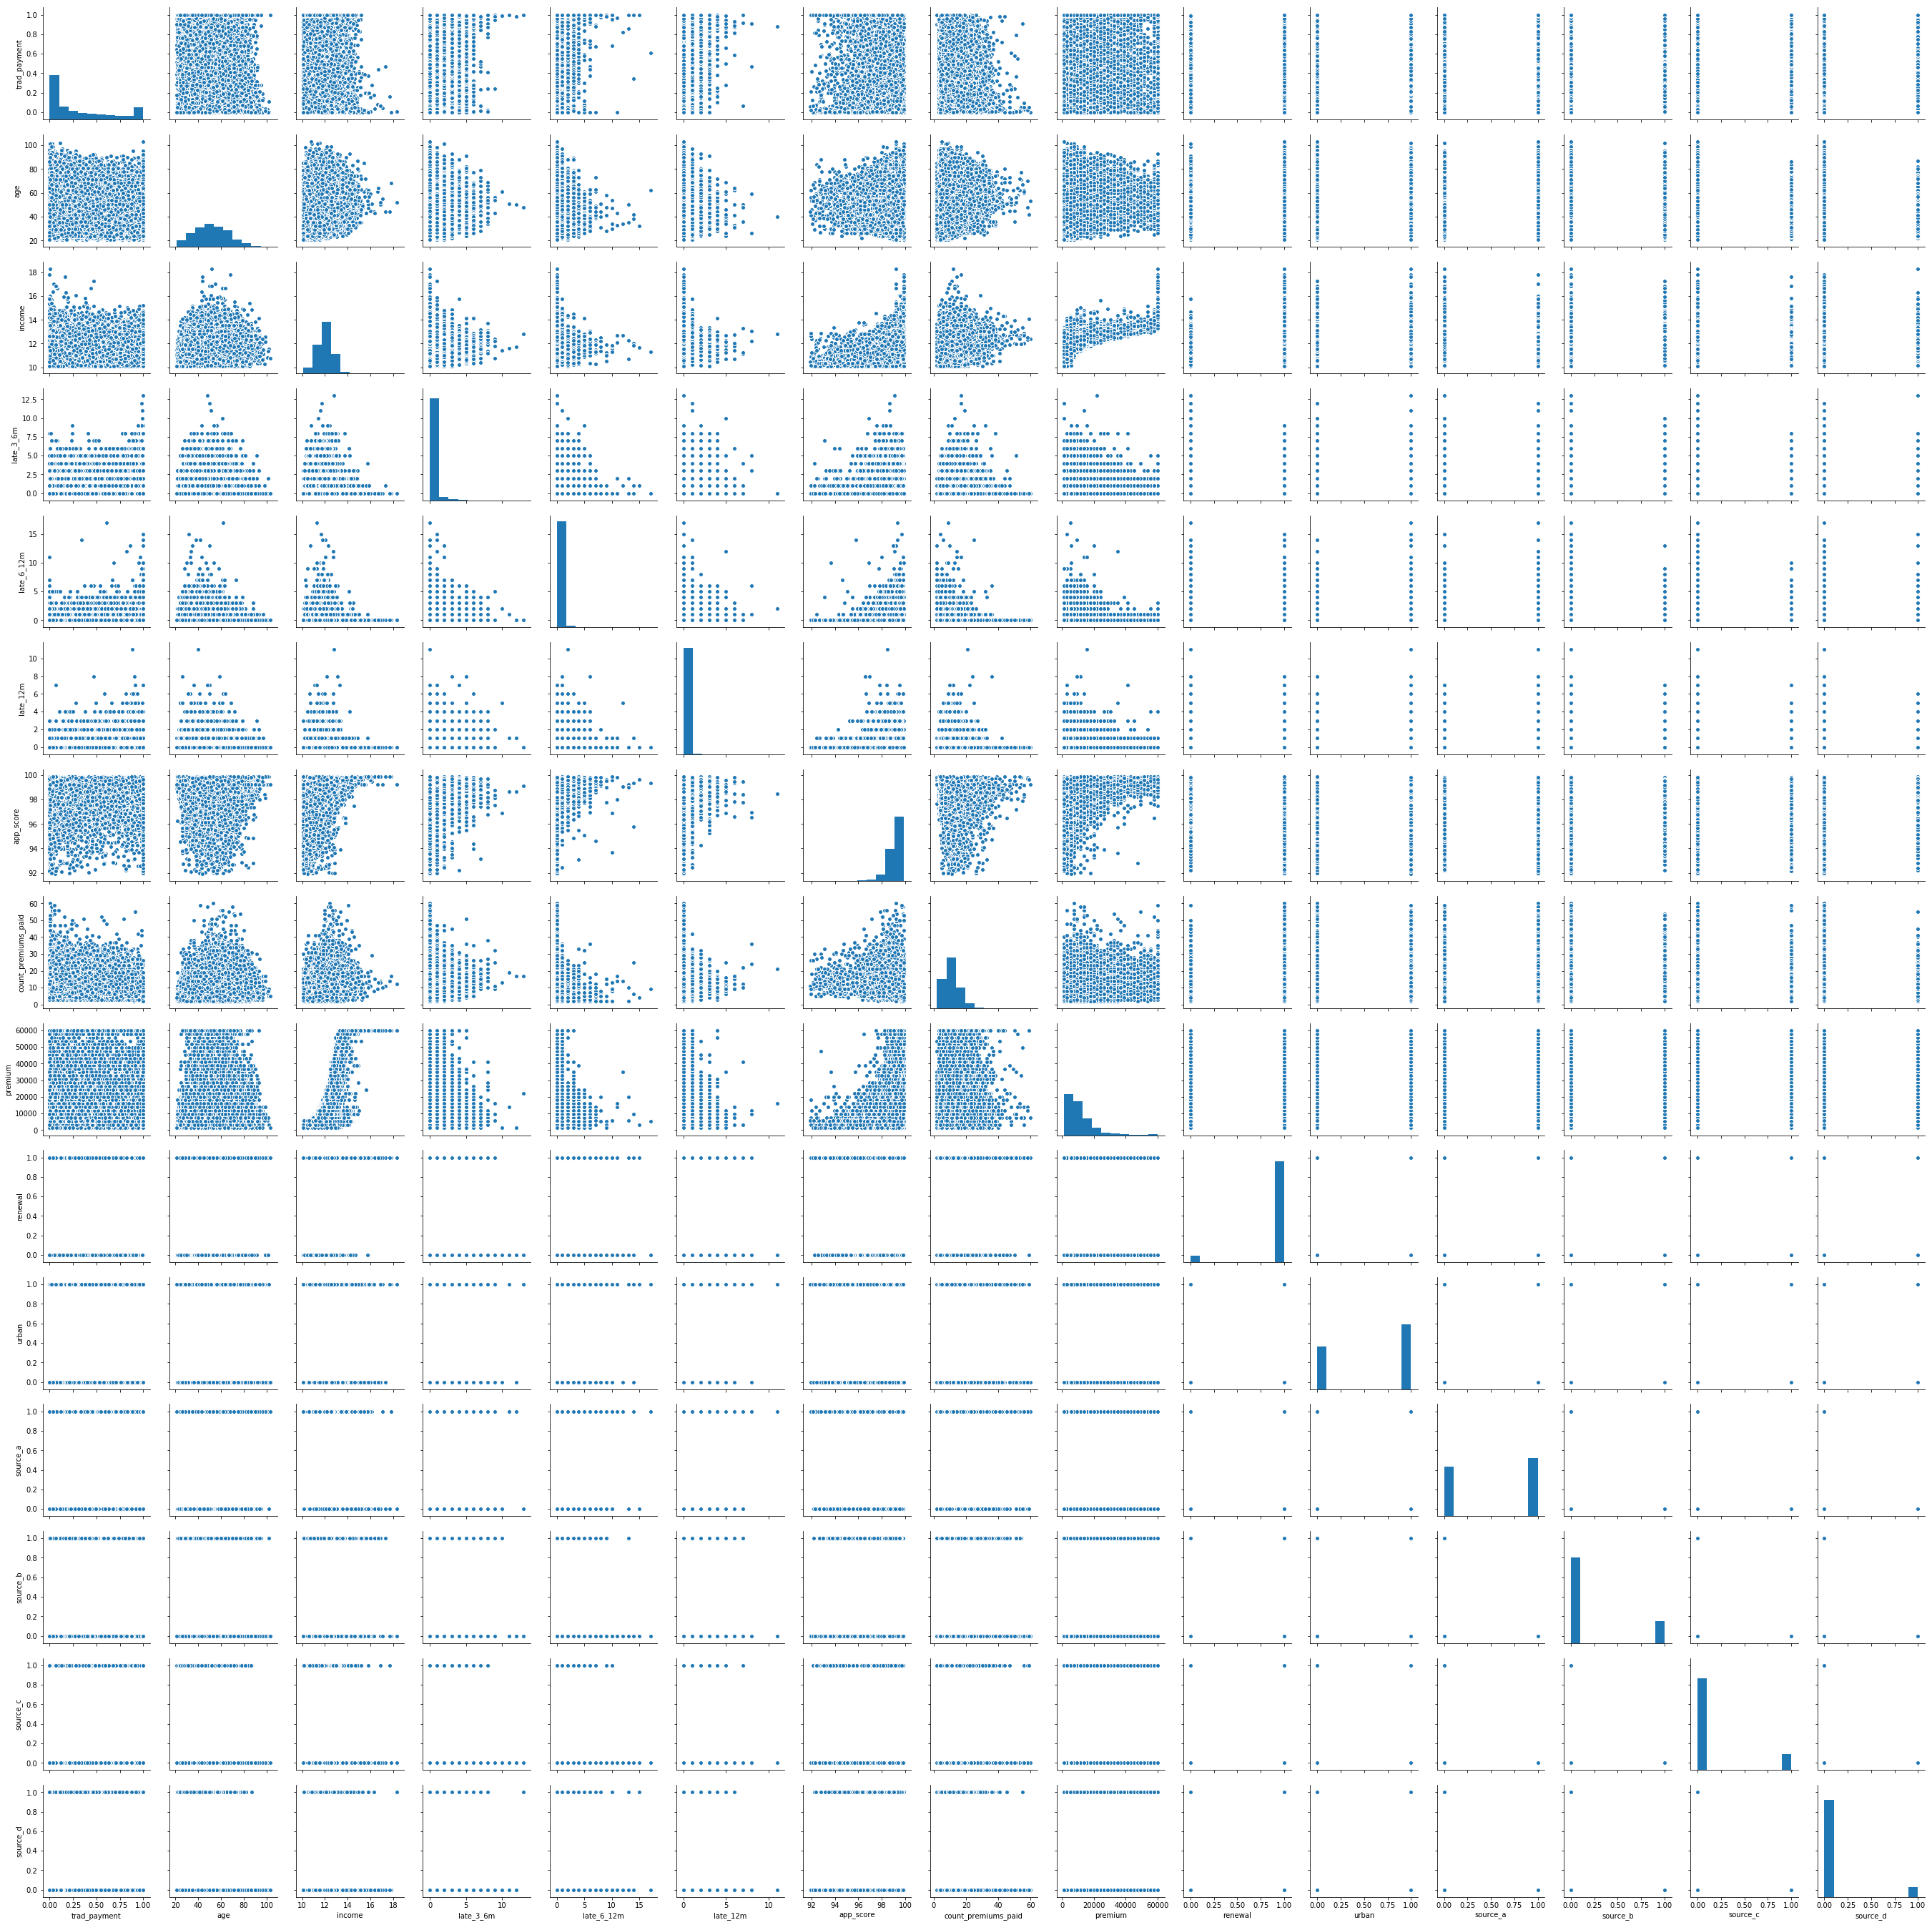

In [32]:
sns.pairplot(train.drop(labels=['source_e'], axis=1))

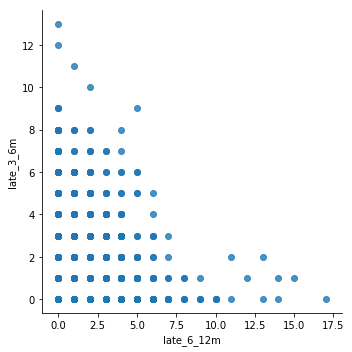

In [33]:
sns.lmplot('late_6_12m', 'late_3_6m', data=train, fit_reg=False)

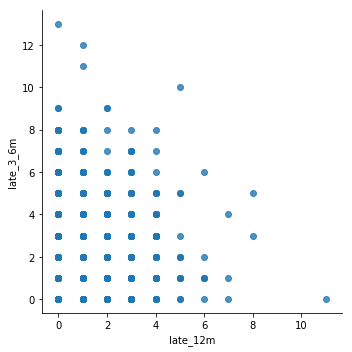

In [34]:
sns.lmplot( 'late_12m','late_3_6m',data=train, fit_reg=False)

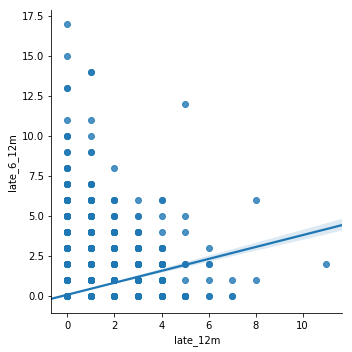

In [35]:
sns.lmplot( 'late_12m','late_6_12m',data=train)

In [36]:
train['inverse_6_3'] = train['late_3_6m'] > (1/train['late_6_12m'])

In [37]:
train['inverse_6_3'].value_counts()

False    78551
True      1302
Name: inverse_6_3, dtype: int64

In [38]:
train['inverse_12_6'] = train['late_6_12m'] > (1/train['late_12m'])

In [39]:
train['inverse_12_6'].value_counts()

False    79184
True       669
Name: inverse_12_6, dtype: int64

In [45]:
train['inverse_12_3'].value_counts()

False    78536
True      1317
Name: inverse_12_3, dtype: int64

In [43]:
train['inverse_12_3'] = train['late_3_6m'] > (1/train['late_12m'])

In [48]:
train['inverse_3_6'] = train['late_6_12m'] > (1/train['late_3_6m'])

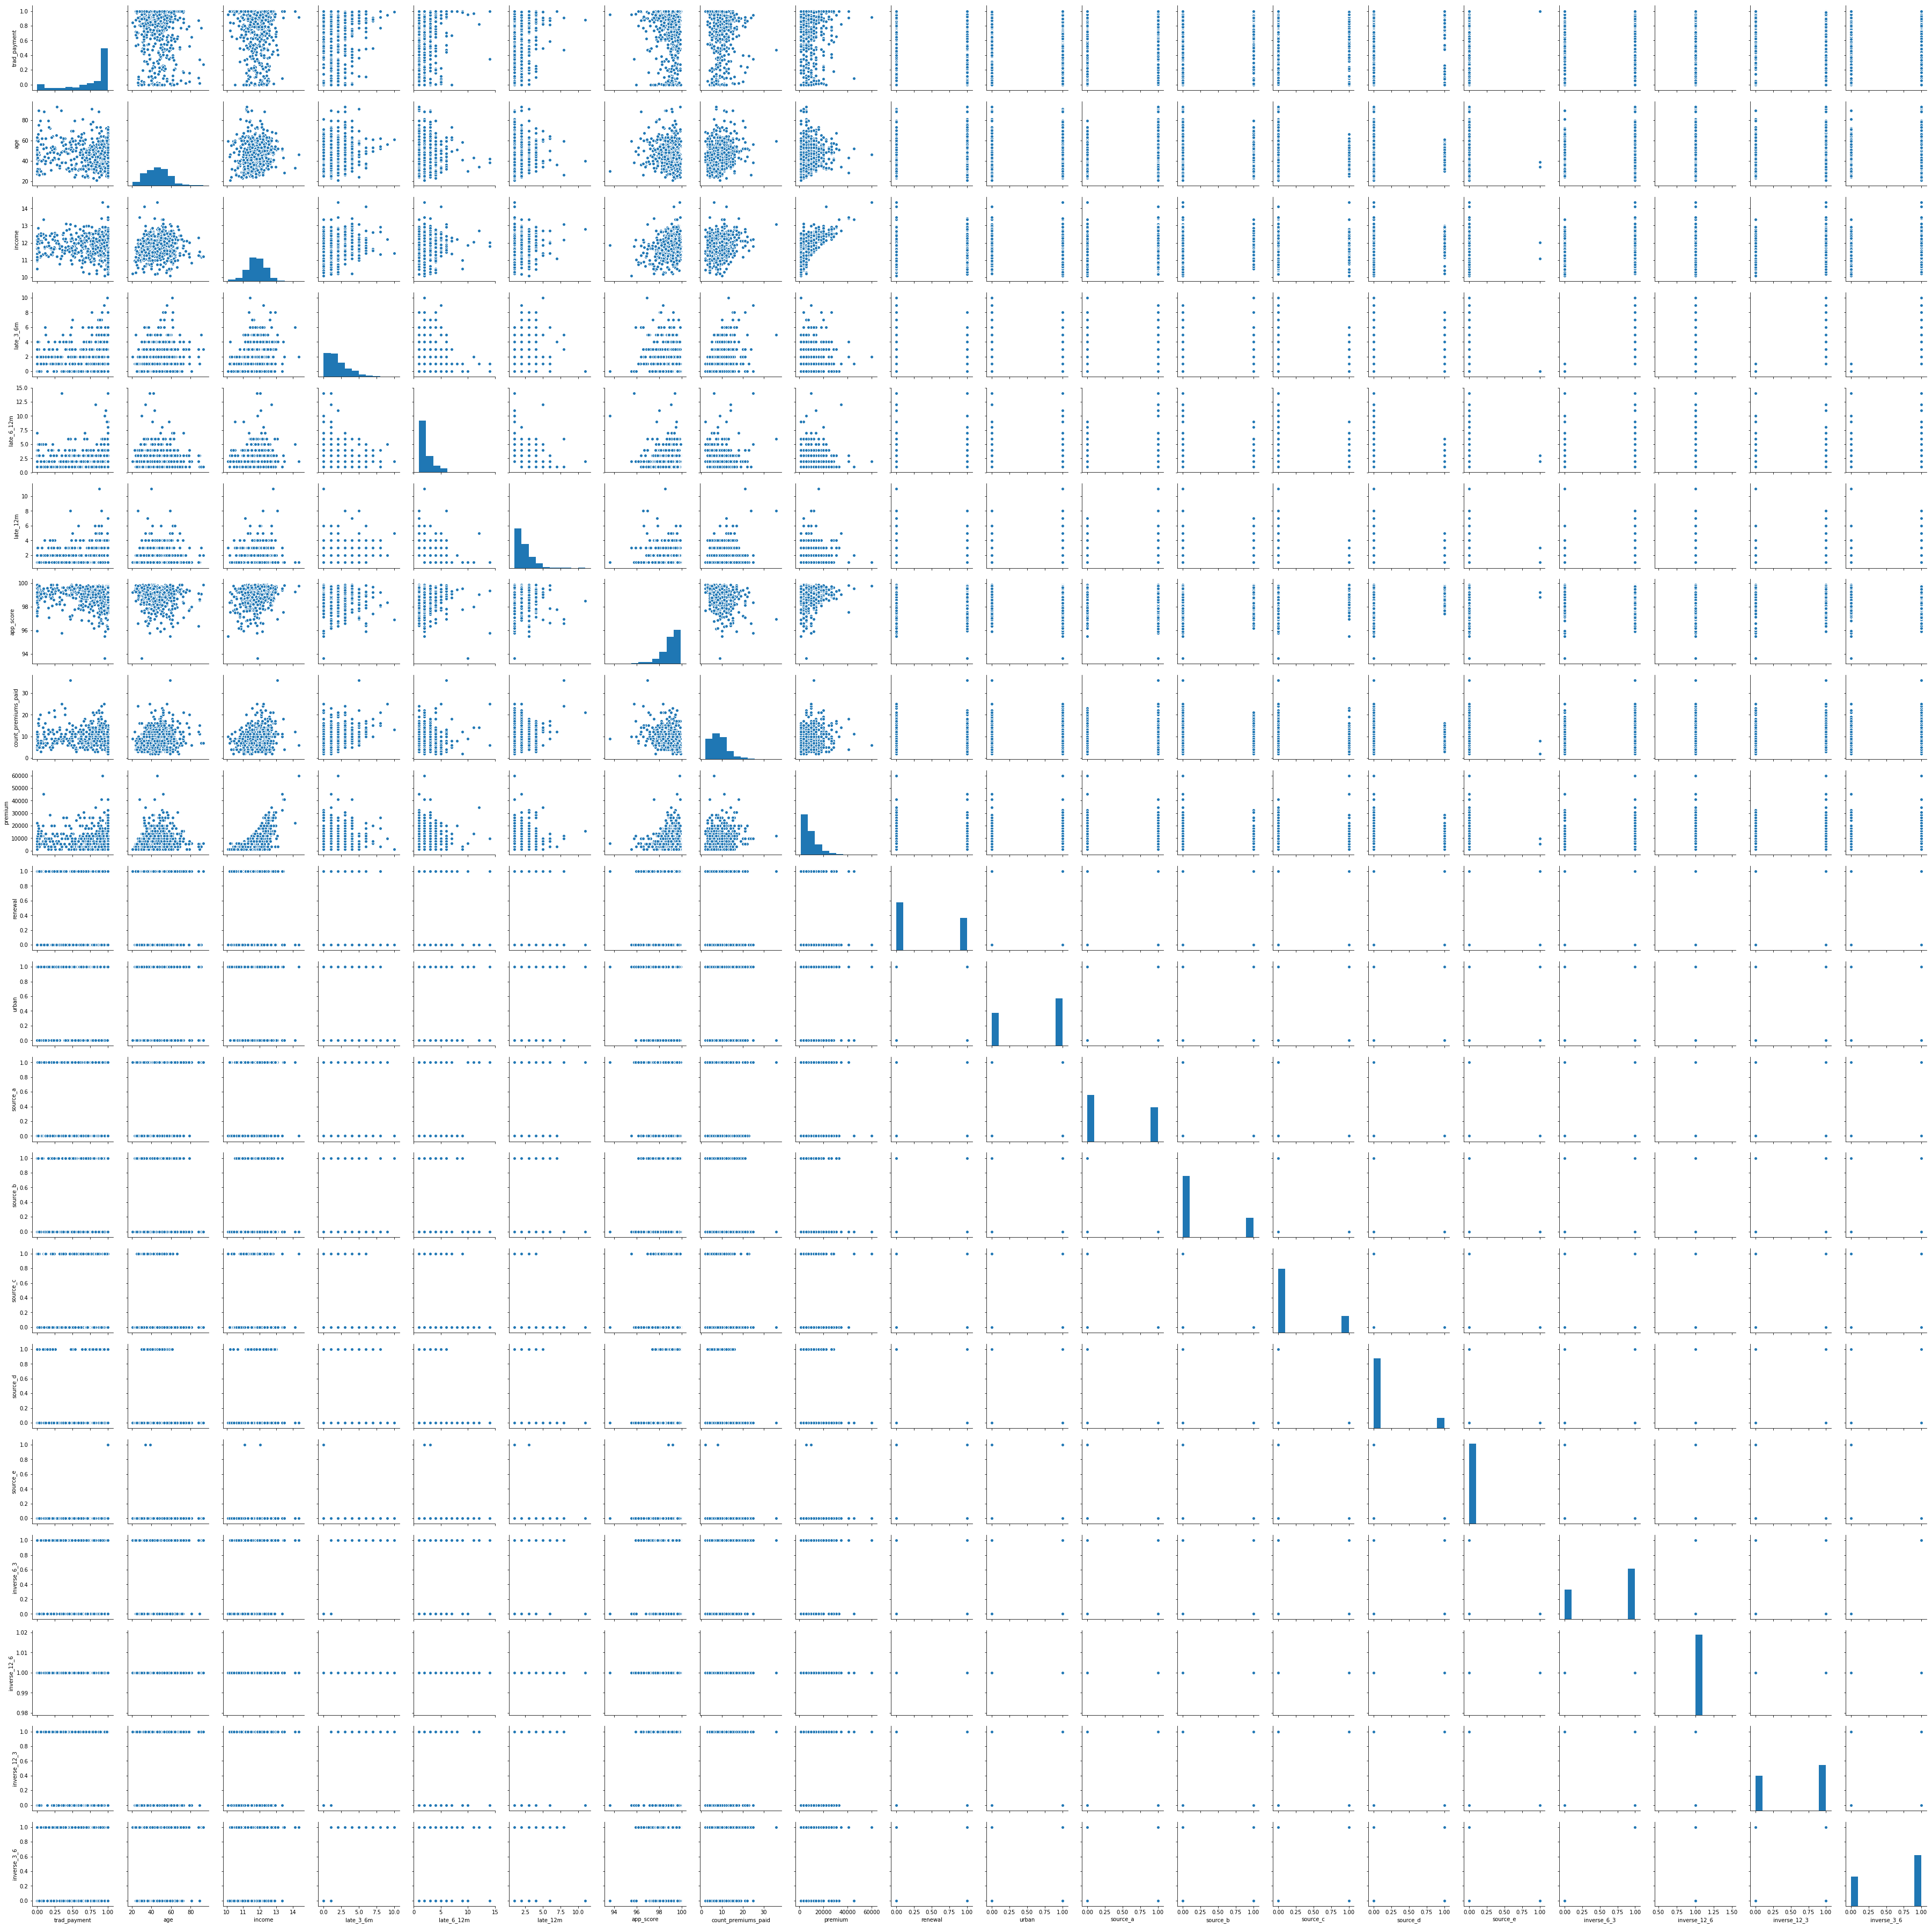

In [52]:
sns.pairplot(train.query('inverse_12_6==1'))

In [46]:
train['renewal'].value_counts()

1    74855
0     4998
Name: renewal, dtype: int64

In [66]:
train[train['inverse_12_6']==1]['renewal'].value_counts(normalize=True)

0    0.596413
1    0.403587
Name: renewal, dtype: float64

In [67]:
train[train['inverse_6_3']==1]['renewal'].value_counts(normalize=True)

0    0.519201
1    0.480799
Name: renewal, dtype: float64

In [47]:
train['total_late'] = 4.5*train['late_3_6m']

79853

In [69]:
train['late_3_12m'] = train['late_3_6m'] + train['late_6_12m']

In [70]:
train['inverse'] = train['late_3_12m'] > (1/train['late_12m'])

In [72]:
train[train['inverse']==1]['renewal'].value_counts(normalize=True)[1]

0.5459803354540197

In [111]:
train['premium_differential'] = train['count_premiums_paid']/(train['age']-20) - train['late_3_6m'] - (1/2)* train['late_6_12m'] - (1/4) * train['late_12m']

In [109]:
train['count_premiums_year'] = train['count_premiums_paid']/(train['age']-20)

/home/kt12/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


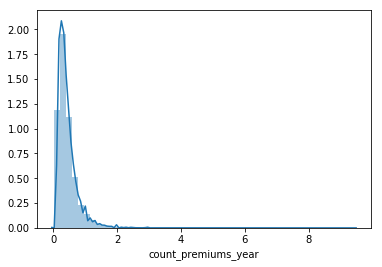

In [110]:
sns.distplot(train['count_premiums_year'])

/home/kt12/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


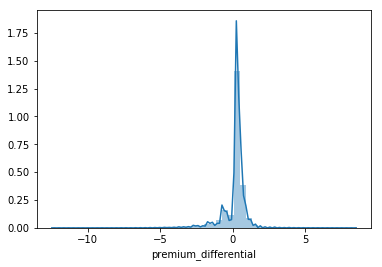

In [112]:
sns.distplot(train['premium_differential'])

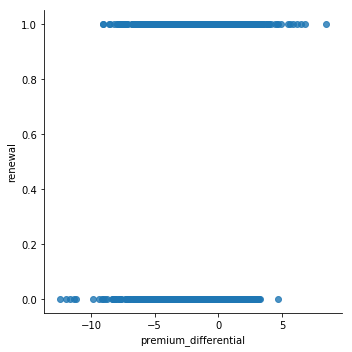

In [113]:
sns.lmplot('premium_differential', 'renewal', train, fit_reg=False)

In [114]:
train['afford'] = train['premium'] / train['income']

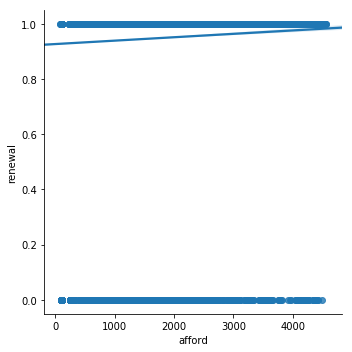

In [116]:
sns.lmplot('afford', 'renewal', train)

In [123]:
train['premium_rate'] = train['premium'] / (train['late_3_6m'] + .5*train['late_6_12m'] + 0.25*train['late_12m'] + 1)

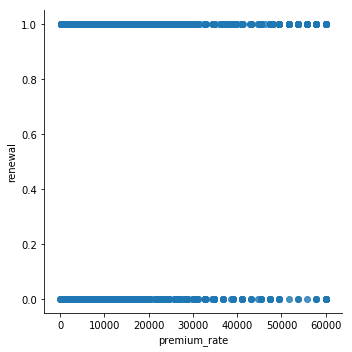

In [124]:
sns.lmplot('premium_rate', 'renewal', train, fit_reg=False)

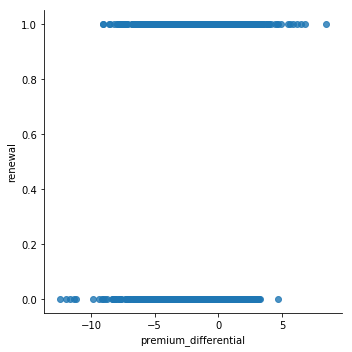

In [126]:
sns.lmplot('premium_differential', 'renewal', train, fit_reg=False)

In [125]:
train.columns

Index(['trad_payment', 'age', 'income', 'late_3_6m', 'late_6_12m', 'late_12m',
       'app_score', 'count_premiums_paid', 'premium', 'renewal', 'urban',
       'source_a', 'source_b', 'source_c', 'source_d', 'source_e',
       'inverse_6_3', 'inverse_12_6', 'inverse_12_3', 'inverse_3_6',
       'late_3_12m', 'inverse', 'premium_differential', 'count_premiums_year',
       'afford', 'premium_rate'],
      dtype='object')

In [128]:
train_fillna = pd.read_csv('train_ZoGVYWq.csv')

In [184]:
X =train_fillna.copy()
X.rename(columns={
    'Income' : 'income',
    'age_in_days' : 'age',
    'perc_premium_paid_by_cash_credit' : 'trad_payment',
    'Count_3-6_months_late' : 'late_3_6m',
    'Count_6-12_months_late' : 'late_6_12m',
    'Count_more_than_12_months_late' : 'late_12m',
    'application_underwriting_score' : 'app_score',
    'no_of_premiums_paid' : 'count_premiums_paid'
    },
    inplace=True)
# Target variable
y = X['renewal'].copy()
X.drop(labels=['id','renewal'], axis=1, inplace=True)

# Rescale non_zero columns
X['age'] = X['age'] / 365
X['income'] = np.log(X['income'])

# binarize urban
X['urban'] = X['residence_area_type'].isin(['Urban'])
X.drop(labels=['residence_area_type'], axis=1, inplace=True)
# encode sourcing - remember to drop E when running prediction (multicollinearity)
X['source_a'] = X['sourcing_channel'].isin(['A'])
X['source_b'] = X['sourcing_channel'].isin(['B'])
X['source_c'] = X['sourcing_channel'].isin(['C'])
X['source_d'] = X['sourcing_channel'].isin(['D'])
X['afford'] = X['income'] / (12 * X['premium'] )
X.drop(labels=['sourcing_channel'], axis=1, inplace=True) 
# Don't normalize binary variables
bi_var = ['urban','source_a', 'source_b', 'source_c', 'source_d']
nan_var = ['late_3_6m', 'late_6_12m', 'late_12m', 'app_score', 'premium_differential']
scale_var = ['trad_payment', 'premium', 'count_premiums_paid', 'age']
# Rescale scale_var
rescale_dict = dict()
rescale_dict['trad_payment_med'] = X['trad_payment'].median()
rescale_dict['trad_payment_std'] = X['trad_payment'].std()
rescale_dict['premium_med'] = X['premium'].median()
rescale_dict['premium_std'] = X['premium'].std()
rescale_dict['afford_med'] = X['afford'].median()
rescale_dict['afford_std'] = X['afford'].std()
rescale_dict['count_premiums_paid_med'] = X['count_premiums_paid'].median()
rescale_dict['count_premiums_paid_std'] = X['count_premiums_paid'].std()
rescale_dict['age_med'] = X['age'].median()
rescale_dict['age_std'] = X['age'].std()
for col in scale_var:
    X[col] = (X[col] - X[col].median())/X[col].std()


In [186]:
y_val = X[~X['late_3_6m'].isnull()]['late_3_6m'].copy()

In [187]:
x_val = X[~X['late_3_6m'].isnull()].drop(['late_3_6m', 'late_6_12m', 'late_12m', 'app_score'], axis=1).copy()

In [188]:
x_full = X[~X['late_3_6m'].isnull()].copy()

In [189]:
var_fit_3 = KNeighborsRegressor(n_neighbors=7, weights='distance')

In [190]:
var_fit_3.fit(x_val, y_val)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='distance')

In [192]:
pred_late_3 = var_fit_3.predict(X[X['late_3_6m'].isnull()].drop(['late_3_6m', 'late_6_12m', 'late_12m', 'app_score'], axis=1))

In [193]:
x_null = X[X['late_3_6m'].isnull()].copy()

In [194]:
x_null['late_3_6m'] = pred_late_3

In [197]:
x_null.shape

(97, 15)

In [198]:
x_full.shape

(79756, 15)

In [200]:
X = pd.concat([x_full, x_null])

In [208]:
np.logspace(-1, 7, 9
           )

array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07])

In [210]:
def svc(X, y):
    # Define classifier='test_66516Ee.csv'
    clf = SVC()
    param_grid = {
    'C': [n for n in np.logspace(-1, 7, 9)]}
    
    
    clf_grid = GridSearchCV(estimator=clf, cv=4, param_grid=param_grid, scoring='roc_auc')
    pipeline = make_pipeline(clf_grid)
    pipeline.fit(X=X, y=y)
    best_clf = clf_grid.best_estimator_
    return best_clf

In [216]:
best_svc = svc(X,y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').